In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Data Science/train_cleaned.csv")

In [ ]:
# Define features and target
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]  # Features
y = df['cluster_category']  # Target variable

In [ ]:
# Before creating LightGBM datasets, ensure labels are in the correct range
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# use the encoded target variable for splitting and creating LightGBM datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=14, stratify=y_encoded)


# show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)

X_train Instances (619244, 4)
X_test Instances (154811, 4)


In [ ]:
from imblearn.over_sampling import SMOTE
# For handling imbalanced data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Create LightGBM dataset format
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [ ]:
# Hyper parameters
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "metric": ["multi_logloss"],
    "boosting_type": "dart",
    "learning_rate": 0.03,
    "class_weight" : "balanced",
    "num_leaves": 20,
    "max_depth": 4,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.6,
    "bagging_fraction": 0.6,
    "bagging_freq": 4,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "num_threads": 4,
    "device": "cpu",
    "early_stopping_rounds": 50
}


In [ ]:
# Dictionary to store training history
evals_result = {}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=["Train", "Validation"],
    num_boost_round=150,
    callbacks=[lgb.early_stopping(20, verbose=True), lgb.record_evaluation(evals_result)],
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 907002, number of used features: 4
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Save the trained model
import joblib
joblib.dump(model, 'LightGBM_Model.pkl')

['LightGBM_Model.pkl']

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = evals_result["Train"]["multi_logloss"]
val_loss = evals_result["Validation"]["multi_logloss"]


epochs = range(len(train_loss))

# Function to plot curves
def plot_curve(train_values, val_values, ylabel, title, train_label, val_label, color1, color2):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_values, label=train_label, color=color1)
    plt.plot(epochs, val_values, label=val_label, color=color2)
    plt.xlabel("Boosting Rounds")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

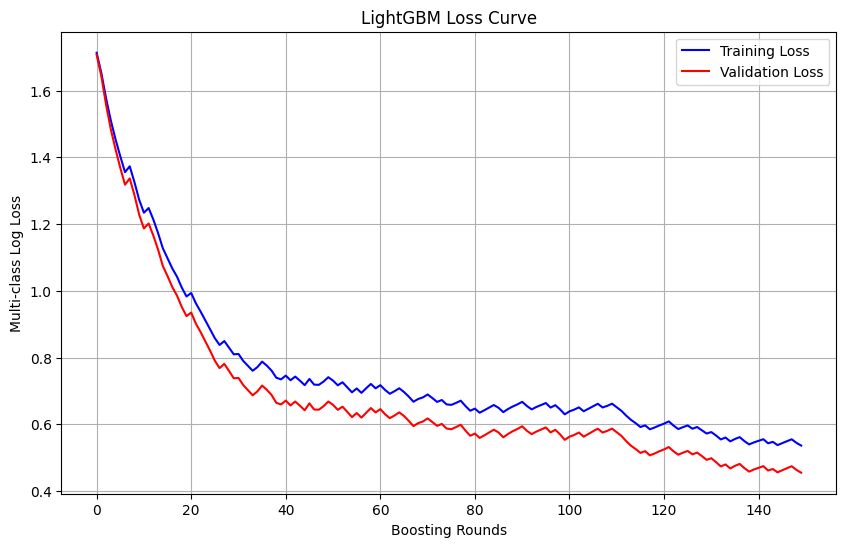

In [ ]:
# Plot loss curve
plot_curve(train_loss, val_loss, "Multi-class Log Loss", "LightGBM Loss Curve", "Training Loss", "Validation Loss", "blue", "red")


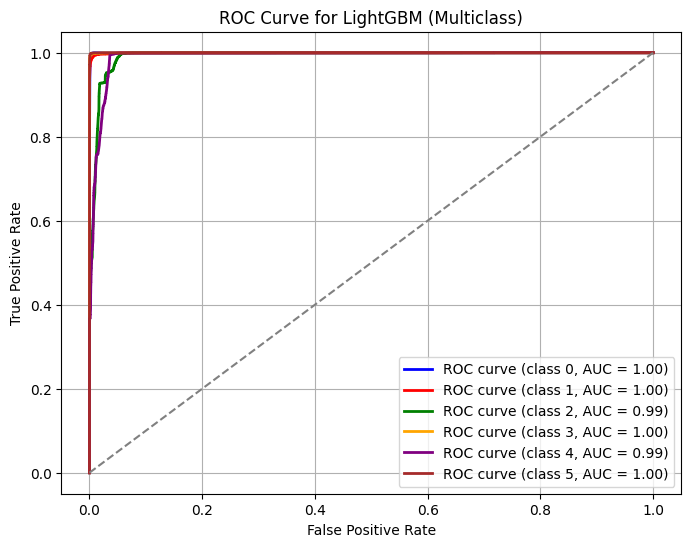

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for all classes
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LightGBM (Multiclass)")
plt.legend(loc="lower right")
plt.grid()

In [ ]:
# Make predictions for both train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert probability outputs to class labels
y_train_pred_classes = [np.argmax(line) for line in y_train_pred]
y_test_pred_classes = [np.argmax(line) for line in y_test_pred]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred_classes)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)

# Print train and test accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_classes))

Train Accuracy: 0.9096
Test Accuracy: 0.9655
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     37792
           1       0.98      1.00      0.99     31010
           2       0.81      0.74      0.77      9778
           3       0.99      0.99      0.99     34485
           4       0.71      0.78      0.75      7905
           5       1.00      0.98      0.99     33841

    accuracy                           0.97    154811
   macro avg       0.91      0.92      0.91    154811
weighted avg       0.97      0.97      0.97    154811



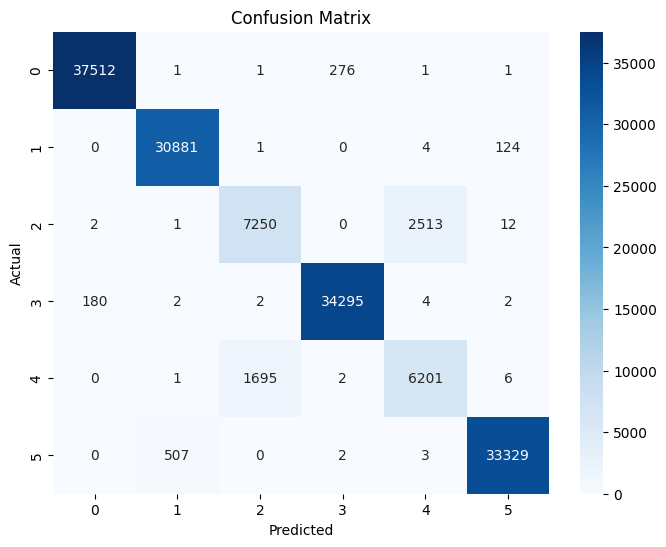

In [ ]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

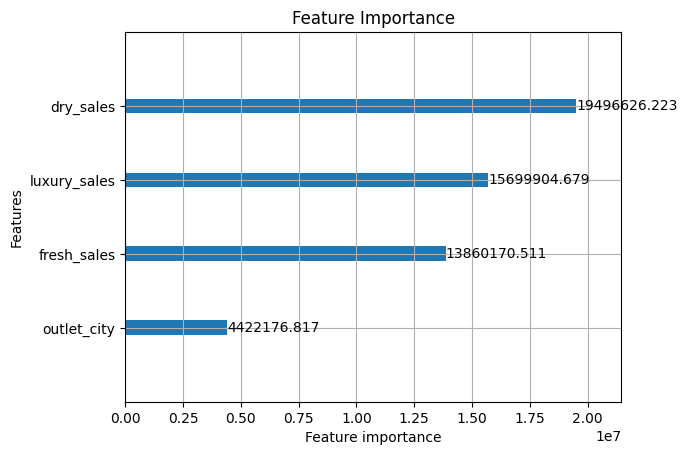

In [ ]:
# Feature importance visualization
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance")
plt.show()

 Test LightGBM Model on Real World Data

In [ ]:
import pandas as pd
test_df = pd.read_csv("/content/drive/MyDrive/Data Science/cleaned_test.csv")

In [ ]:
# Extract features used in training
X_test = test_df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

In [ ]:
import numpy as np
# Predict cluster categories
cluster_probabilities = model.predict(X_test)  # Get probabilities for each cluster
cluster_category = np.argmax(cluster_probabilities, axis=1)  # Get predicted cluster category

In [ ]:
# Add predictions to the test data
test_df["cluster_category"] = cluster_category

In [ ]:
# Select relevant columns for output
output_data = test_df[["Customer_ID", "cluster_category"]]

In [ ]:
# Save predictions to a CSV file
output_file = "predictions.csv"
output_data.to_csv(output_file, index=False)